In [20]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
from os.path import join
from collections import defaultdict
import numpy as np
import joblib
from tqdm import tqdm
import sys
from copy import deepcopy
sys.path.append('../notebooks')
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import viz, analyze_helper
from neuro.features.questions.gpt4 import QS_35_STABLE
from neurosynth import term_dict, term_dict_rev, get_neurosynth_flatmaps
neurosynth_compare = __import__('04_neurosynth_compare')
import viz
import neurosynth
from cortex import mni
import os
from statsmodels.stats.multitest import multipletests
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
setup_freesurfer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### compute correlations with qa flatmaps and plot avgs

In [8]:
# setting = 'shapley_neurosynth'
# setting = 'full_neurosynth'
# setting = 'individual_gpt4''
for settings in [
    # ['full_neurosynth_pc'],
    # ['full_neurosynth_wordrate_pc'],
    # ['full_35_pc'],
    # ['full_35_wordrate_pc'],
    # ['full_neurosynth'],
    # ['full_neurosynth_wordrate'],
    # ['full_35'],
    # ['full_35_wordrate'],
    # ['individual_gpt4'],
    ['individual_gpt4_ndel=1_pc_new'],
    # ['individual_gpt4_pc_new'],

]:
    print('settings', settings)
    # settings = ['']  # shapley_neurosynth, individual_gpt4
    subjects = ['UTS01', 'UTS02', 'UTS03']
    # subjects = [f'UTS0{i}' for i in range(1, 9)]

    # comparison hyperparams
    apply_mask = True
    frac_voxels_to_keep = 0.1  # 0.10
    frac_voxels_to_keep_list = [frac_voxels_to_keep]
    # hyperparams
    out_dir = join(repo_dir, 'qa_results',
                   'neurosynth_compare', '___'.join(settings))
    os.makedirs(out_dir, exist_ok=True)

    # load flatmaps
    flatmaps_qa_dicts_by_subject = neurosynth.load_flatmaps_qa_dicts_by_subject(
        subjects, settings)

    corrs_df = neurosynth_compare.compute_corrs_df(
        frac_voxels_to_keep, subjects, flatmaps_qa_dicts_by_subject, apply_mask)

    # compute pvals
    # pvals_subject = compute_pvals_for_subject(
    # corrs_df, 'UTS01', frac_voxels_to_keep_list)
    # pvals_subject.style.background_gradient().format(precision=3)

    # compute mni space correlations
    # corrs_df_mni = neurosynth_compare.compute_mni_corr_df(
    #     flatmaps_qa_dicts_by_subject, flatmaps_gt_dict_mni, qs)
    # print('avg', corrs_df_mni.loc['avg'])
    # corrs_df_mni.to_pickle(join(out_dir, 'corrs_df_mni.pkl'))
    # corrs_df_mni.style.background_gradient(axis=None, cmap="coolwarm_r", vmin=-
    #                                        corrs_df_mni.abs().max().max(), vmax=corrs_df_mni.abs().max().max()).format(precision=3).to_html(
    #     join(out_dir, 'corrs_df_mni.html'))

settings ['individual_gpt4_ndel=1_pc_new']


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:53<00:00, 17.94s/it]


In [9]:
corrs_df.to_pickle('corrs_df/neurosynth.pkl')

mean corr 0.16867169138402271
UTS01 corr 0.14902346479856324
UTS02 corr 0.17563887020604355
UTS03 corr 0.18135273914746136
saved to /home/chansingh/fmri/qa_results/neurosynth_compare/individual_gpt4_ndel=1_pc_new


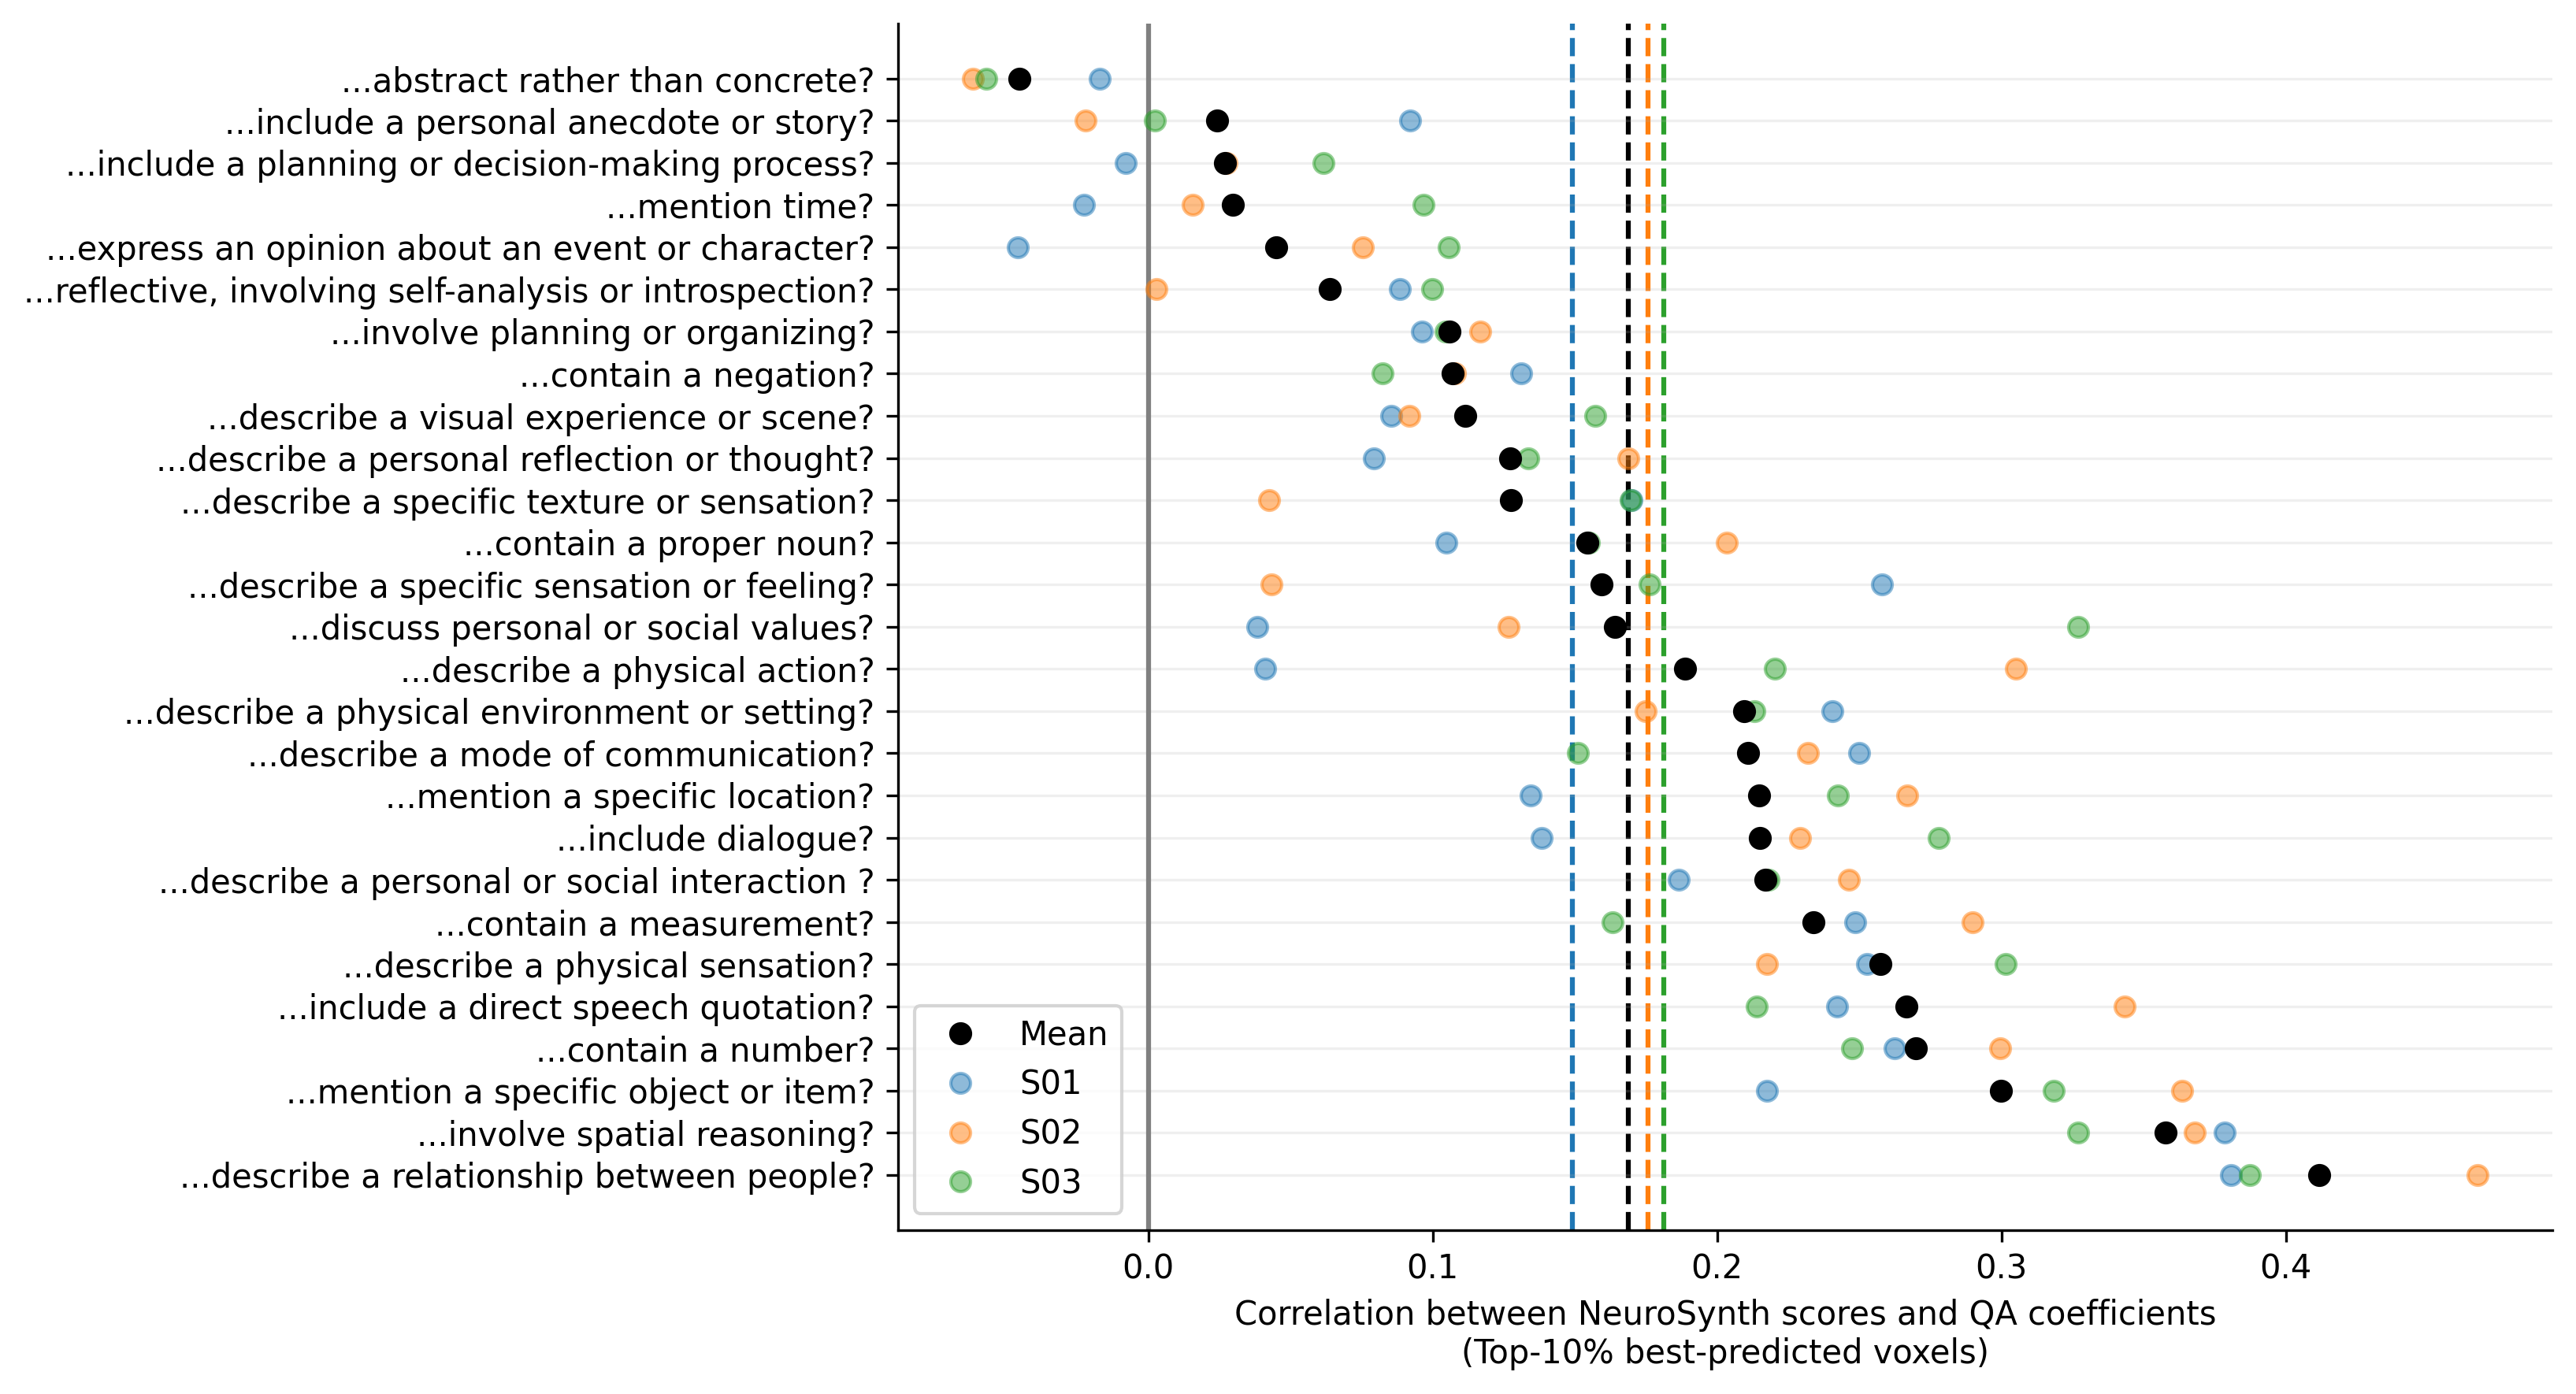

In [11]:
plt.figure(figsize=(11, 6), dpi=300)
neurosynth_compare.plot_corrs_df(
    corrs_df, out_dir, plot_val=f'corrs_{frac_voxels_to_keep}',
    xlab=f'Correlation between NeuroSynth scores and QA coefficients\n(Top-{int(100*frac_voxels_to_keep)}% best-predicted voxels)')
print('saved to', out_dir)

### statistical tests

In [ ]:
qs_35 = sorted([x[0] for x in corrs_df.questions.unique()])

for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    # eng1000_dir = join(PROCESSED_DIR, subject.replace(
    # 'UT', ''), 'eng1000_weights.pkl')
    # flatmaps_null = joblib.load(eng1000_dir)
    baseline_distrs = []
    for subject in ['UTS01', 'UTS02', 'UTS03']:
        flatmaps_qa_list = [
            flatmaps_qa_dicts_by_subject[subject][k] for k in qs_35]
        flatmaps_null = np.array(joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), 'resp_chunks_1trs.pkl')))

        # print('shape', flatmaps_eng1000.shape)
        corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
            'UT', ''), 'corrs_test_35.pkl')).values[0]
        _, baseline_distr = viz.compute_pvals(
            flatmaps_qa_list, frac_voxels_to_keep,
            corrs_df[f'corrs_{frac_voxels_to_keep}'].values,
            flatmaps_null=flatmaps_null, mask_corrs=corrs_test)

        baseline_distrs.append(baseline_distr)

        # get what fraction of 'corrs_perm_eng1000' column is greater than 'corrs'
    #     corrs_df[f'pval_{frac_voxels_to_keep}'] = pvals
    #     corrs_df[f'baseline_distr_{frac_voxels_to_keep}'] = basline_distr
    # for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    #     corrs_df[f'pval_{frac_voxels_to_keep}_err_corrected'] = multipletests(
    #         pvals, method='fdr_bh', alpha=0.5)[1]

In [ ]:
vals_baseline = np.array(baseline_distrs).mean(axis=0)
vals_alt = corrs_df.groupby('questions')[
    f'corrs_{frac_voxels_to_keep}'].mean().sort_index().values

n = len(vals_alt)
print(np.mean(vals_alt))

# permutation test on mean
n_samples = 1000
means_baseline = [
    np.mean(np.random.choice(vals_baseline.flatten(), size=n, replace=False))
    for i in range(n_samples)
]
print('mean test p', np.mean(np.array(means_baseline) >= np.mean(vals_alt)))

# permutation test on individuals
pvals = []
for i in range(len(vals_baseline)):
    pvals.append(np.mean(vals_baseline[i] >= vals_alt[i]))
pvals = multipletests(
    pvals, method='fdr_bh', alpha=0.05)[1]
print('individual pvals (err corrected)', pvals)

### Evaluate possible matches

In [15]:
corrs_tab = corrs_df.pivot_table(
    index='questions', columns='subject', values='corrs_0.1'
)
# add mean col
corrs_tab['mean'] = corrs_tab.mean(axis=1)
corrs_tab = corrs_tab.sort_values('mean', ascending=False).reset_index()

In [16]:
with pd.option_context('display.float_format', '{:.3f}'.format,
                       'display.max_rows', None,
                       'display.max_columns', None):
    display(corrs_tab.sort_values(
        by=['questions', 'mean'], ascending=[True, False]).set_index('questions')[['mean']])

subject,mean
questions,
"(Does the input contain a measurement?, arithmetic)",0.234
"(Does the input contain a number?, arithmetic)",0.270
"(Does the input describe a specific texture or sensation?, sensation)",0.127
"(Does the input involve planning or organizing?, planning)",0.106
"(Does the sentence contain a negation?, negative)",0.107
"(Does the sentence contain a proper noun?, nouns)",0.154
"(Does the sentence describe a personal or social interaction that leads to a change or revelation?, social-interaction)",0.217
"(Does the sentence describe a personal reflection or thought?, thoughts)",0.127
"(Does the sentence describe a physical action?, action)",0.189


In [21]:
tab_matches = defaultdict(list)
for x in term_dict_rev:
    (k, v) = x
    tab_matches['q'].append(k)
    tab_matches['term'].append(v)

for k in QS_35_STABLE:
    if k not in tab_matches['q']:
        tab_matches['q'].append(k)
        tab_matches['term'].append('NO MATCH')

tab_matches = pd.DataFrame(tab_matches)
tab_matches['q'] = [analyze_helper.abbrev_question(
    q) for q in tab_matches['q']]
tab_matches.to_csv('tab_matches.csv', index=False)

### View flatmaps in 1 plot

In [ ]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results',
                               'neurosynth', setting + '_corrs_df.pkl'))

In [ ]:
setting = 'shapley_neurosynth'
for subject in ['UTS01', 'UTS02', 'UTS03']:
    img_dir1 = join(repo_dir, 'qa_results', 'neurosynth',
                    subject, 'neurosynth')
    img_dir2 = join(repo_dir, 'qa_results', 'neurosynth',
                    subject, setting)

    # read images and combine them with their filenames on a single plot
    # fnames = os.listdir(img_dir1)
    # fnames = [f for f in fnames if f.endswith('.png')]
    # only keep the ones that are in both directories
    # fnames = [f for f in fnames if f in os.listdir(img_dir2)]

    corrs = corrs_df[corrs_df['subject'] == subject]
    # corrs = corrs.sort_values(f'corrs_{frac_voxels_to_keep}', ascending=False)
    fnames = [v + '.png' for v in corrs['questions'].values]

    n = len(fnames)
    C = 4
    R = int(np.ceil(n / C))

    fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
    axs = axs.flatten()
    for i in range(len(axs)):
        axs[i].axis('off')
    for i, fname in enumerate(fnames):
        img1 = plt.imread(join(img_dir1, fname))
        img2 = plt.imread(join(img_dir2, fname))
        axs[i].imshow(np.concatenate([img1, img2], axis=1))
        axs[i].set_title(
            f'{term_dict_rev[fname[:-4]]} ({corrs["corrs"].values[i]:0.3f})', fontsize=8)

    # add text in bottom right of figure
    fig.text(0.99, 0.01, f'{subject}\nNeurosynth on left, QA on right',
             ha='right', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(join(repo_dir, 'qa_results', 'neurosynth',
                subject, f'flatmaps_{setting}_{subject}.png'), dpi=300)
    plt.close()